In [136]:
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
# from keras.layers.convolutional import*
from keras.metrics import categorical_crossentropy

from tensorflow.keras.optimizers import Adam
from keras.layers import BatchNormalization


import numpy as np
import matplotlib.pyplot as plt
import os
import random
from collections import defaultdict

In [137]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [138]:
device_name = tf.test.gpu_device_name()
device_name

'/device:GPU:0'

In [139]:
# classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
train_path = '/content/drive/MyDrive/emotion_detection/train' # mainly used this for training, testing, and validation because this dataset was big enough
test_path = '/content/drive/MyDrive/emotion_detection/test'

# EDA

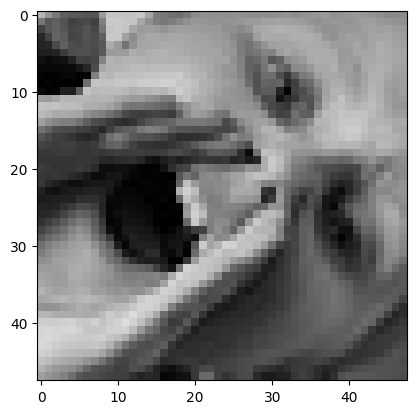

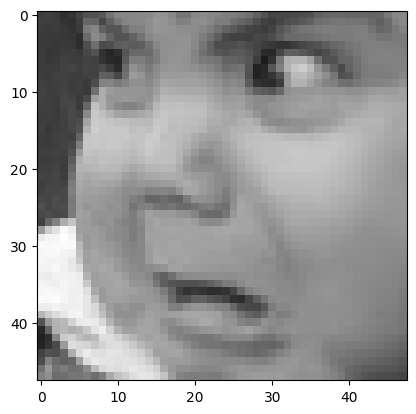

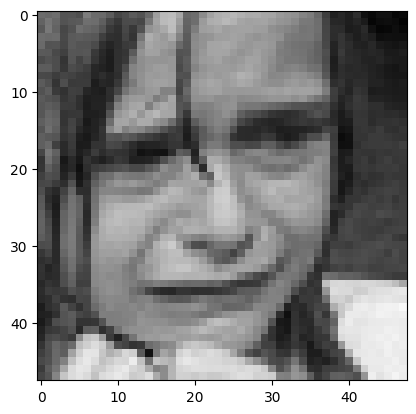

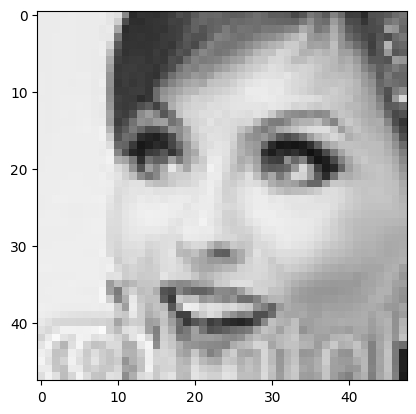

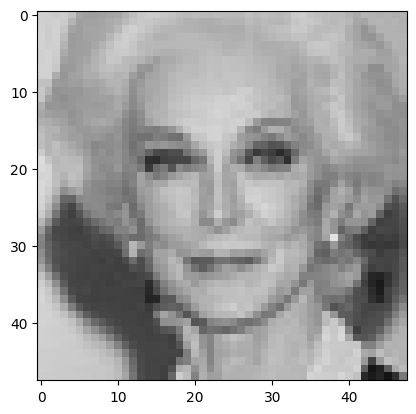

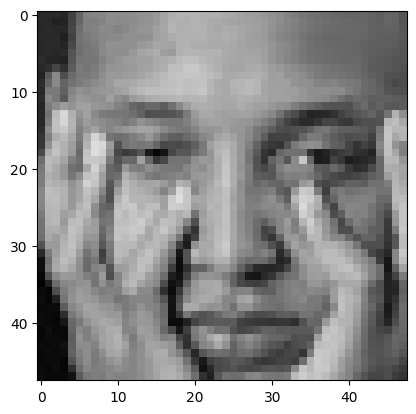

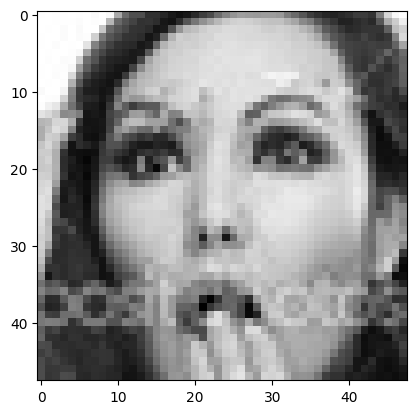

In [140]:
# display the first image in each category
for emo_class in classes:
  path = os.path.join(train_path, emo_class)
  for img in os.listdir(path):
      img_arr = cv2.imread(os.path.join(path, img))
      plt.imshow(cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB))
      plt.show()
      break # to only show the first image

# Pre-processing

In [141]:
HEIGHT = 48 # default size of our data from FER dataset
WIDTH = 48 # default size of our data from FER dataset

BATCH_SIZE = 10

In [112]:
dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/emotion_detection/train',
    shuffle=True,
    image_size = (HEIGHT, WIDTH),
    batch_size = BATCH_SIZE
)

Found 5920 files belonging to 7 classes.


In [114]:
len(dataset)


592

In [115]:
class_names = dataset.class_names
class_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [142]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size = BATCH_SIZE,
    subset='training'
)

Found 4739 images belonging to 7 classes.


In [143]:
def create_train_test_validation_splits(data, shuffle=True, shuffle_size=10000):

    # shuffle data before splitting data
    if shuffle:
        data = data.shuffle(shuffle_size, seed=6)

    train_split = 0.7
    test_split = 0.15
    val_split = 0.15 # i wanted at least 15% for the validation data

    train_size = int(train_split * len(data))
    test_size = int(test_split * len(data))

    # create partitioned datasets
    train = data.take(train_size)
    test = data.skip(train_size).take(test_size)
    val = data.skip(train_size).skip(test_size)

    return train, test, val

In [120]:
train, test, val = create_train_test_validation_splits(dataset)

In [144]:
print(f'train size: {len(train)} batches')
print(f'test size: {len(test)} batches')
print(f'validation size: {len(val)} batches')

train size: 473 batches
test size: 59 batches
validation size: 60 batches


In [122]:
IMAGE_SIZE = 224 # because the MobileNetV2 expects images of size 224 × 224 pixels
EPOCHS = 10
INPUT_SHAPE = (None, IMAGE_SIZE, IMAGE_SIZE, 3)

## loading in our pre-trained MobileNetV2 model

In [145]:
pre_trained_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

pre_trained_model.trainable=False

In [124]:
# create pre-processing pipeline

prepoc = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    #layers.experimental.preprocessing.Rescaling(1.0/255),
])

# Model

In [147]:
model = Sequential([
    prepoc,
    pre_trained_model,
    Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=INPUT_SHAPE),
    MaxPooling2D((2,2)),
    Dropout(0.4),
    Flatten(),
    #BatchNormalization(axis=1),
    Dense(len(class_names), activation='softmax')
])

In [148]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [149]:
history = model.fit(
    train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val
)

Epoch 1/10
473/473 [==============================] - 28s 38ms/step - loss: 1.9419 - accuracy: 0.2137 - val_loss: 1.9035 - val_accuracy: 0.2133
Epoch 2/10
473/473 [==============================] - 18s 28ms/step - loss: 1.8937 - accuracy: 0.2163 - val_loss: 1.8893 - val_accuracy: 0.1983
Epoch 3/10
473/473 [==============================] - 21s 35ms/step - loss: 1.8780 - accuracy: 0.2199 - val_loss: 1.8709 - val_accuracy: 0.2083
Epoch 4/10
473/473 [==============================] - 20s 29ms/step - loss: 1.8748 - accuracy: 0.2230 - val_loss: 1.8928 - val_accuracy: 0.1933
Epoch 5/10
473/473 [==============================] - 20s 31ms/step - loss: 1.8757 - accuracy: 0.2127 - val_loss: 1.8812 - val_accuracy: 0.2183
Epoch 6/10
473/473 [==============================] - 21s 35ms/step - loss: 1.8746 - accuracy: 0.2112 - val_loss: 1.8695 - val_accuracy: 0.2283
Epoch 7/10
473/473 [==============================] - 23s 38ms/step - loss: 1.8749 - accuracy: 0.2201 - val_loss: 1.8550 - val_accuracy:

# Testing

In [150]:
scores = model.evaluate(test)

59/59 [==============================] - 5s 17ms/step - loss: 1.8627 - accuracy: 0.2339


In [155]:
# scores

In [152]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

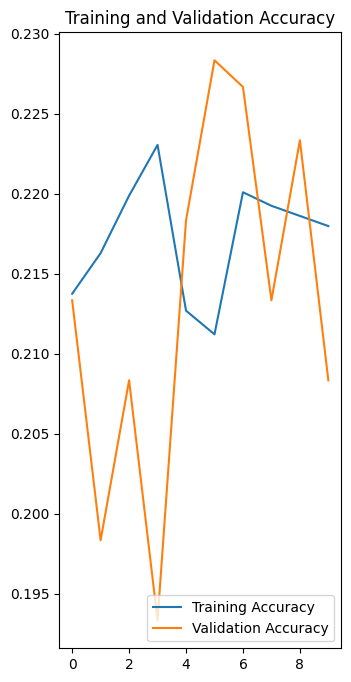

In [153]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(history.params['epochs']), acc, label='Training Accuracy')
plt.plot(range(history.params['epochs']), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

Text(0.5, 1.0, 'Training and Validation Loss')

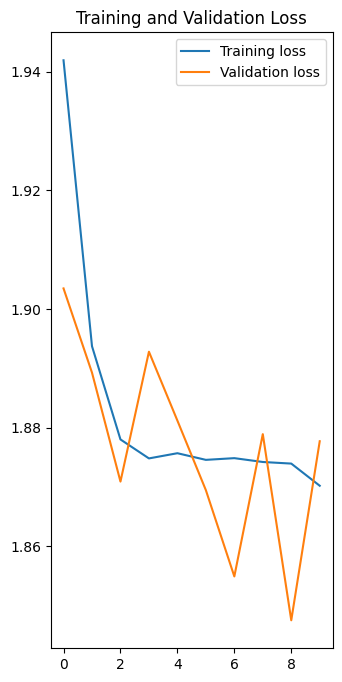

In [154]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,2)
plt.plot(range(history.params['epochs']), loss, label='Training loss')
plt.plot(range(history.params['epochs']), val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')